# Imports and constants

In [1]:
from src.lib import *
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy import stats
import random
import numpy as np
from scipy.stats import f_oneway
from evaluate import load
import torch
from transformers import BertTokenizer, BertForMaskedLM
from transformers import logging
logging.set_verbosity_error()


# === Constants and Configuration ===
PATH_GRAPHS = 'graphs/'
PATH_TABLES = 'tables/'
os.makedirs(PATH_GRAPHS, exist_ok=True)
os.makedirs(PATH_TABLES, exist_ok=True)

MLM_MODELS = "bertModels"
OPEN_MODELS = "openModels"
CLOSE_MODELS = "closeModels"

LABELSIZE = 15

PALETTE_ALL = [
    (0.6509803921568628, 0.807843137254902, 0.8901960784313725),  # light blue
    (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),  # dark blue
    (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),  # light green
    (0.2, 0.6274509803921569, 0.17254901960784313),  # dark green
    (0.984313725490196, 0.6039215686274509, 0.6),  # light red
    (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),  # dark red
    (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),  # light orange
    (1.0, 0.4980392156862745, 0.0),  # dark orange
    (0.792156862745098, 0.6980392156862745, 0.8392156862745098),  # light purple
    (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),  # dark purple
    (1.0, 1.0, 0.6),  # light yellow
    (0.6941176470588235, 0.34901960784313724, 0.1568627450980392),  # brown
    (0.650, 0.847, 0.831),  # light teal
    (0.106, 0.482, 0.427)   # dark teal
]

MARKER_COLOR_MAP = {
    UNMARKED: "black",
    NONQUEER: "dodgerblue",
    QUEER: "crimson"
}


COLOR = 'color'
LINESTYLE = 'linestyle'
LABEL = 'label'
PATTERN = 'pattern'
PERSPECTIVE_MAP = {
    TOXICITY:         {LABEL: "Toxicity", COLOR: PALETTE_ALL[1]},
    SEVERE_TOXICITY:  {LABEL: "Severe Toxicity", COLOR: PALETTE_ALL[3]},
    INSULT:           {LABEL: "Insult", COLOR: PALETTE_ALL[5]},
    IDENTITY_ATTACK:  {LABEL: "Identity Attack", COLOR: PALETTE_ALL[7]},
    PROFANITY:        {LABEL: "Profanity", COLOR: PALETTE_ALL[9]},
    THREAT:           {LABEL: "Threat", COLOR: PALETTE_ALL[11]},
}

REGARD_MAP = {
    'Negative': PALETTE_ALL[5],
    'Neutral':  PALETTE_ALL[7],
    'Positive': PALETTE_ALL[3],
}

def compute_mean_ci(data, confidence=0.95):
    confidence = float(confidence)
    data = np.array(data)
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else 0
    sem = stats.sem(data) if n > 1 else 0
    h = sem * stats.t.ppf((1 + confidence) / 2., n - 1) if n > 1 else 0
    return round(mean,3), round(std,3), round(h,3)

Using device: cpu


# Sentiment Analysis, Toxicity and Lexical Diversity Graphs

/var/folders/6c/zlq1y_8d5j7635vxqzj6z99c0000gn/T/ipykernel_33220/2743981672.py:120: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: apply_ci(g.drop(columns=[MODEL, TYPE]), DIVERSITY))


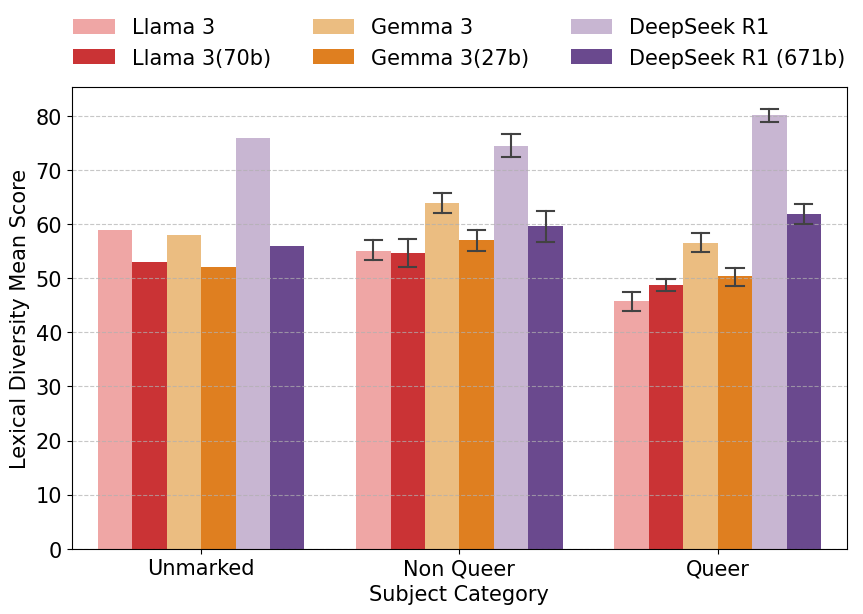

In [2]:
def get_palette(models):
    if models == MODEL_MLM:
        return PALETTE_ALL[0:4]
    elif models == MODEL_OPEN:
        return PALETTE_ALL[4:10]
    else:
        return PALETTE_ALL[10:14]
    
def plot_barplot(df, models, img_name, metric):
    ylabel = {
        VADER: 'VADER Average Score',
        PERSPECTIVE: 'Perspective Average Score',
        DIVERSITY: 'Lexical Diversity Mean Score'
    }[metric]

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df,
        x=TYPE,
        y=metric,
        hue=MODEL,
        palette=get_palette(models),
        err_kws={"linewidth": 1.5},
        capsize=0.4
    )

    ax.tick_params(axis='both', labelsize=LABELSIZE)
    ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)
    plt.ylabel(ylabel, fontsize=LABELSIZE)
    plt.xlabel('Subject Category', fontsize=LABELSIZE)

    
    ncol = 3 if model_list == MODEL_OPEN else 2
    plt.legend(title=MODEL, fontsize=LABELSIZE, title_fontsize=LABELSIZE)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=ncol, title=None, frameon=False, fontsize = LABELSIZE)
    #if metric == DIVERSITY:
        #ax.set(ylim=(25, 85))
        #ax.get_legend().remove()
    #     sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, -0.3), ncol=3, title=None, frameon=False)
    # else:
    #     ax.get_legend().remove()

    plt.tight_layout
    os.makedirs(f"{PATH_GRAPHS}{metric}/", exist_ok=True)
    plt.savefig(f"{PATH_GRAPHS}{metric}/{img_name}.png")
    plt.show()

def apply_ci(group, metric):
    mean, std, ci = compute_mean_ci(group[metric].dropna())
    return pd.Series({metric: mean, 'CI': ci, 'STD': std})

def prepare_vader_data(models, prompt_num=PROMPT_DEFAULT):
    all_scores = []
    for model in models:
        df = pd.read_csv(f"{PATH_EVALUATIONS}prompt_{prompt_num}/{model}.csv")
        df[MODEL] = MODELS_LABELS.get(model, model)
        df[TYPE] = pd.Categorical(df[TYPE], categories=SUBJ_CATEGORIES, ordered=True)
        all_scores.append(df[[MODEL, TYPE, VADER]])

    df_combined = pd.concat(all_scores).reset_index(drop=True)
    #display(df_combined)
    grouped = (
        df_combined.groupby([MODEL, TYPE], observed=True)
        .apply(lambda g: apply_ci(g.drop(columns=[MODEL, TYPE]), VADER))
        .reset_index()
    )
    #display(grouped)
    return df_combined, grouped

def prepare_perspective_data(models, prompt_num=PROMPT_DEFAULT):
    all_scores = []
    for model in models:
        df = pd.read_csv(f"{PATH_EVALUATIONS}prompt_{prompt_num}/{model}.csv")
        df[MODEL] = MODELS_LABELS.get(model, model)
        df[TYPE] = pd.Categorical(df[TYPE], categories=SUBJ_CATEGORIES, ordered=True)
        df[PERSPECTIVE] = df[[f"{PERSPECTIVE} {cat}" for cat in PERSPECTIVE_CATEGORIES]].mean(axis=1)
        all_scores.append(df[[MODEL, TYPE, PERSPECTIVE]])

    df_combined = pd.concat(all_scores).reset_index(drop=True)
    #display(df_combined)
    grouped = (
        df_combined.groupby([MODEL, TYPE], observed=True)
        .apply(lambda g: apply_ci(g.drop(columns=[MODEL, TYPE]), PERSPECTIVE))
        .reset_index()
    )
    #display(grouped)
    return df_combined, grouped

def prepare_lexical_diversity_data(models, prompt_num=PROMPT_DEFAULT):
    all_scores = []

    for model in models:
        df = pd.read_csv(f"{PATH_EVALUATIONS}prompt_{prompt_num}/{model}.csv")

        for category in SUBJ_CATEGORIES:
            df_cat = df[df[TYPE] == category]#.dropna(subset=[PREDICTION])
            n_samples = len(df_cat[PREDICTION])

            if category == UNMARKED:
                # print(model)
                # print(n_samples)
                # print(len(set(df_cat[PREDICTION])))
                # display(set(df_cat[PREDICTION]))
                diversity = round(len(set(df_cat[PREDICTION])) / n_samples * 100, 2)
                all_scores.append({MODEL: MODELS_LABELS[model], TYPE: category, DIVERSITY: diversity})
            else:
                n_batches = n_samples // 100
                for _ in range(n_batches):
                    sample = df_cat.sample(n=100, replace=False, random_state=random.randint(0, 10000))
                    diversity = round(len(set(sample[PREDICTION])) / 100 * 100, 2)
                    all_scores.append({MODEL: MODELS_LABELS[model], TYPE: category, DIVERSITY: diversity})

    df_combined = pd.DataFrame(all_scores)
    df_combined[TYPE] = pd.Categorical(df_combined[TYPE], categories=SUBJ_CATEGORIES, ordered=True)
    
    #display(df_combined)
    
    grouped = (
        df_combined.groupby([MODEL, TYPE], observed=True)
        .apply(lambda g: apply_ci(g.drop(columns=[MODEL, TYPE]), DIVERSITY))
        .reset_index()
    )
    
    #display(grouped)
    return df_combined, grouped

metric_configs = [
    #(VADER, prepare_vader_data),
    #(PERSPECTIVE, prepare_perspective_data),
    (DIVERSITY, prepare_lexical_diversity_data)
]

all_outputs = {metric: [] for metric, _ in metric_configs}

for model_list, model_list_name in [
    #(MODEL_MLM, MLM_MODELS),
    (MODEL_OPEN, OPEN_MODELS),
    #(MODEL_CLOSE, CLOSE_MODELS)
]:
    for metric, prepare_func in metric_configs:
        raw_df, grouped_df = prepare_func(model_list)
        all_outputs[metric].append(grouped_df)
        plot_barplot(raw_df, model_list, model_list_name, metric=metric)

for metric, dfs in all_outputs.items():
    pd.concat(dfs).to_csv(os.path.join(PATH_TABLES, f'{metric}.csv'), index=False)

# Regard Graph

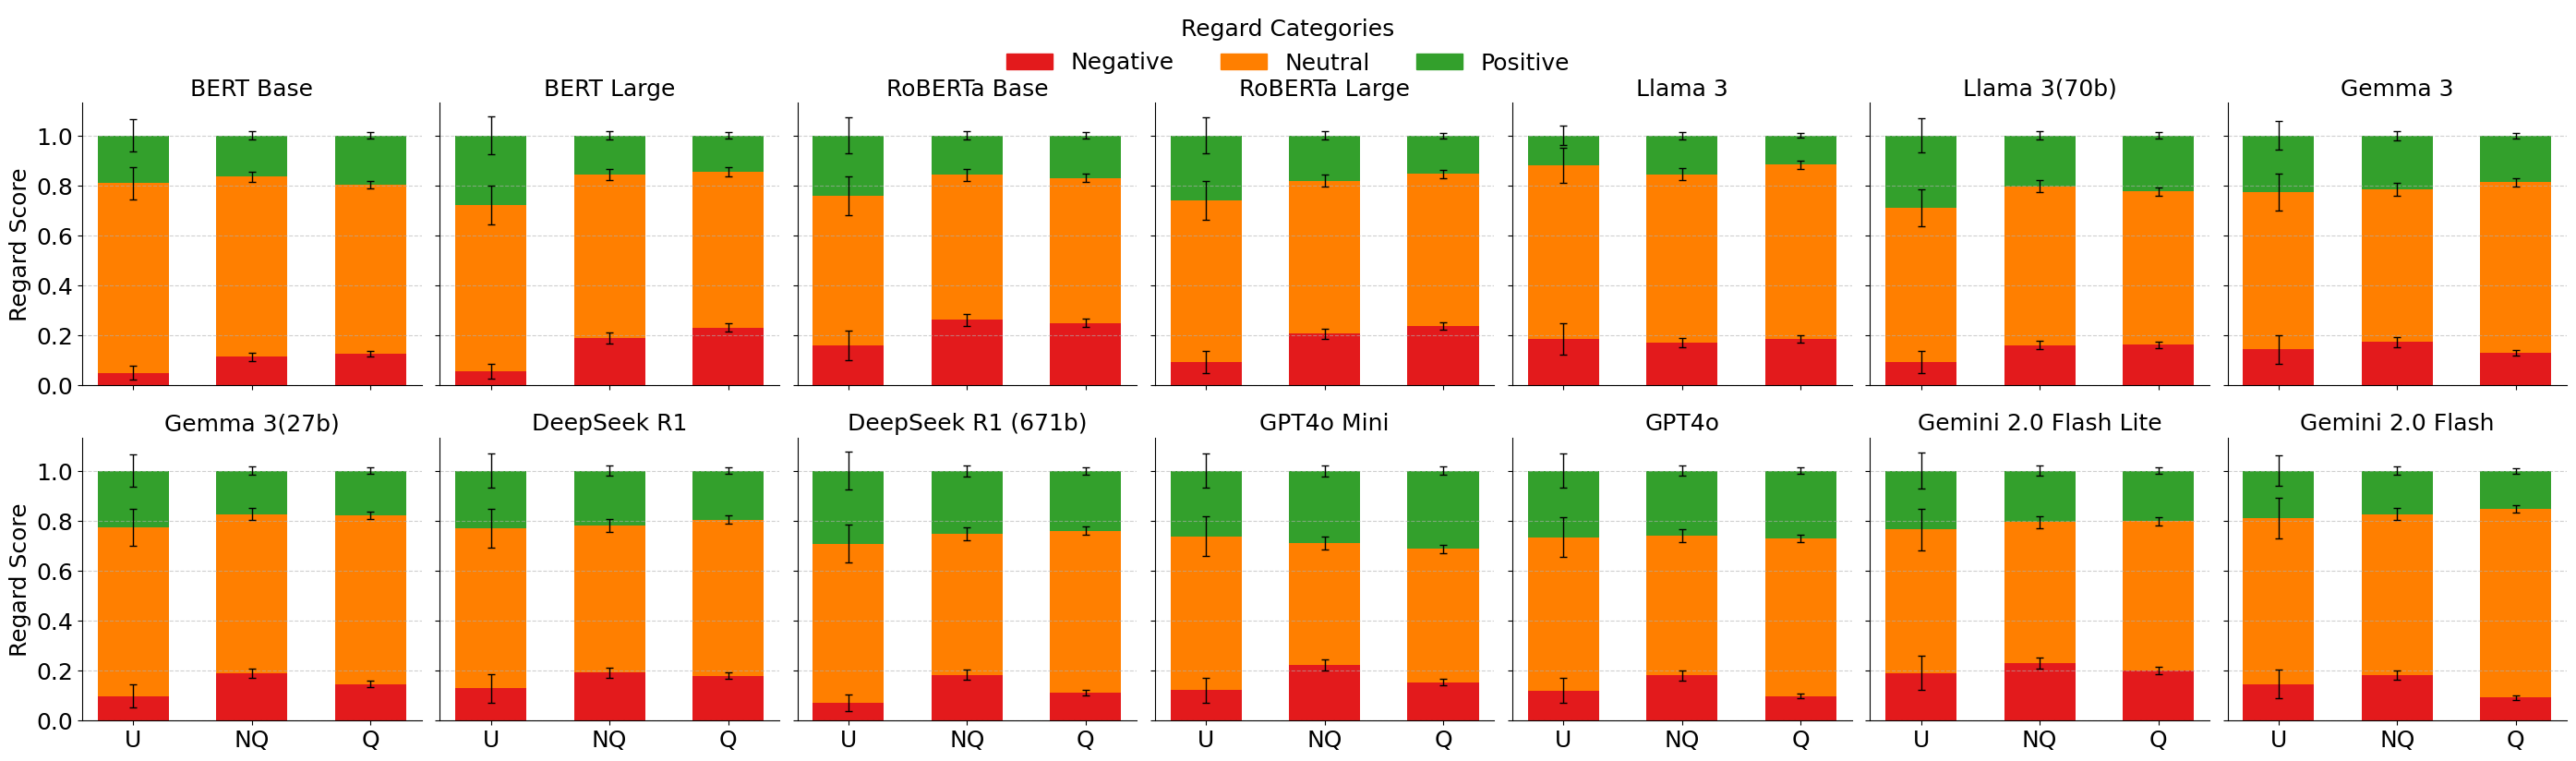

In [3]:
def regard_bar_graph(data):
    LABELSIZE = 18
    models_per_row=7

    g = sns.FacetGrid(
        data,
        col=MODEL,
        col_wrap=models_per_row,
        height=4,
        sharey=True
    )

    def stacked_barplot(data, **kwargs):
        ax = plt.gca()
        bottoms = np.zeros(len(SUBJ_CATEGORIES))

        for i, category in enumerate(REGARD_CATEGORIES):
            subset = data[data[REGARD] == category].sort_values(SUBJECT)
            scores = subset["Score"].values
            cis = subset["CI"].values
            x = np.arange(len(SUBJ_CATEGORIES))
            ax.bar(
                x,
                scores,
                bottom=bottoms,
                color=REGARD_MAP[category],
                width=0.6,
                label=category
            )
            ax.errorbar(
                x,
                bottoms + scores,
                yerr=cis,
                fmt='none',
                ecolor='black',
                capsize=3,
                linewidth=1
            )
            bottoms += scores

        ax.set_xticks(x)
        ax.set_xticklabels(["U", "NQ", "Q"], fontsize=LABELSIZE)
        ax.tick_params(axis='y', labelsize=LABELSIZE)
        ax.set_xlabel("")
        ax.set_ylabel("Regard Score", fontsize=LABELSIZE)
        ax.grid(visible=True, axis='y', linestyle='--', alpha=0.6)

    g.map_dataframe(stacked_barplot)
    g.set_titles("{col_name}", size=LABELSIZE)
    g.set_axis_labels("", "Regard Score")
    g.fig.subplots_adjust(top=0.88)

    handles = [plt.Rectangle((0, 0), 1, 1, color=REGARD_MAP[category]) for category in REGARD_CATEGORIES]
    g.fig.legend(
        handles,
        REGARD_CATEGORIES,
        title="Regard Categories",
        title_fontsize=LABELSIZE,
        fontsize=LABELSIZE,
        loc="upper center",
        ncol=len(REGARD_CATEGORIES),
        frameon=False,
        bbox_to_anchor=(0.5, 1.04),
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    os.makedirs(f"{PATH_GRAPHS}{REGARD}/", exist_ok=True)
    plt.savefig(f"{PATH_GRAPHS}{REGARD}/all.png", bbox_inches='tight')
    plt.show()
    plt.close()
    
def prepare_regard_data(models, prompt_num=PROMPT_DEFAULT):
    records = []

    for model in models:
        data = pd.read_csv(f"{PATH_EVALUATIONS}prompt_{prompt_num}/{model}.csv")
        for subjCat in SUBJ_CATEGORIES:
            df = data[data[TYPE] == subjCat]
            means, cis = [], []

            for cat in REGARD_CATEGORIES:
                vals = df[f"Regard {cat}"].dropna().values
                m, _, h = compute_mean_ci(vals)
                means.append(m)
                cis.append(h)

            score_sum = sum(means)
            if score_sum == 0:
                normalized = [0] * len(means)
                norm_cis = [0] * len(cis)
            else:
                normalized = [v / score_sum for v in means]
                norm_cis = [h / score_sum for h in cis]

            for i, category in enumerate(REGARD_CATEGORIES):
                records.append({
                    MODEL: MODELS_LABELS.get(model, model),
                    SUBJECT: subjCat,
                    REGARD: category,
                    "Score": normalized[i],
                    "CI": norm_cis[i],
                })

    df_long = pd.DataFrame(records)
    df_long[SUBJECT] = pd.Categorical(df_long[SUBJECT], categories=SUBJ_CATEGORIES, ordered=True)
    df_long[REGARD] = pd.Categorical(df_long[REGARD], categories=REGARD_CATEGORIES, ordered=True)

    #display(df_long)
    return df_long

df_regard = prepare_regard_data(MODEL_LIST_FULL)
df_regard.to_csv(f"{PATH_TABLES}{REGARD}.csv", index=False)
regard_bar_graph(data=df_regard)

# Marker Charts

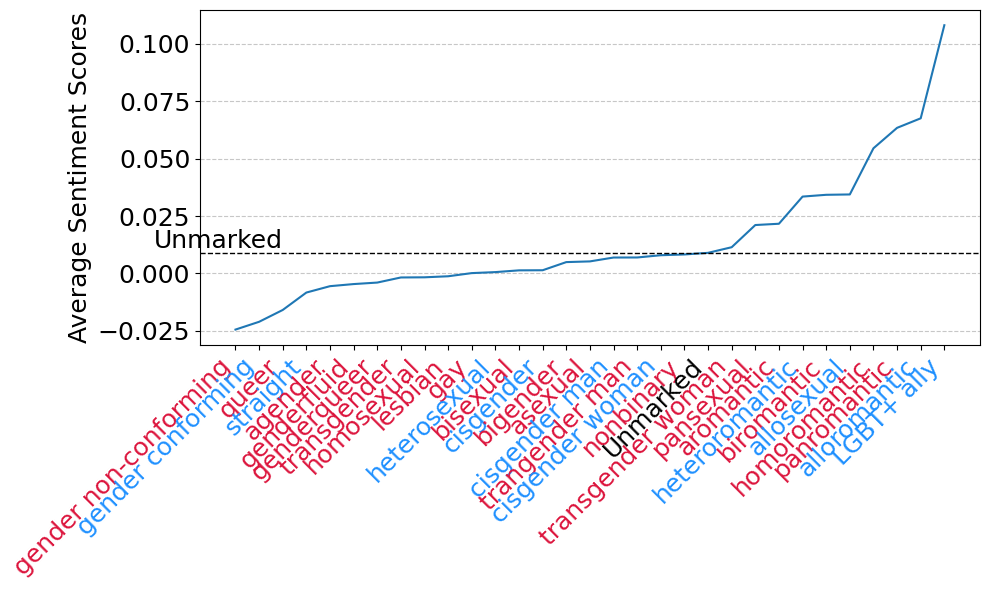

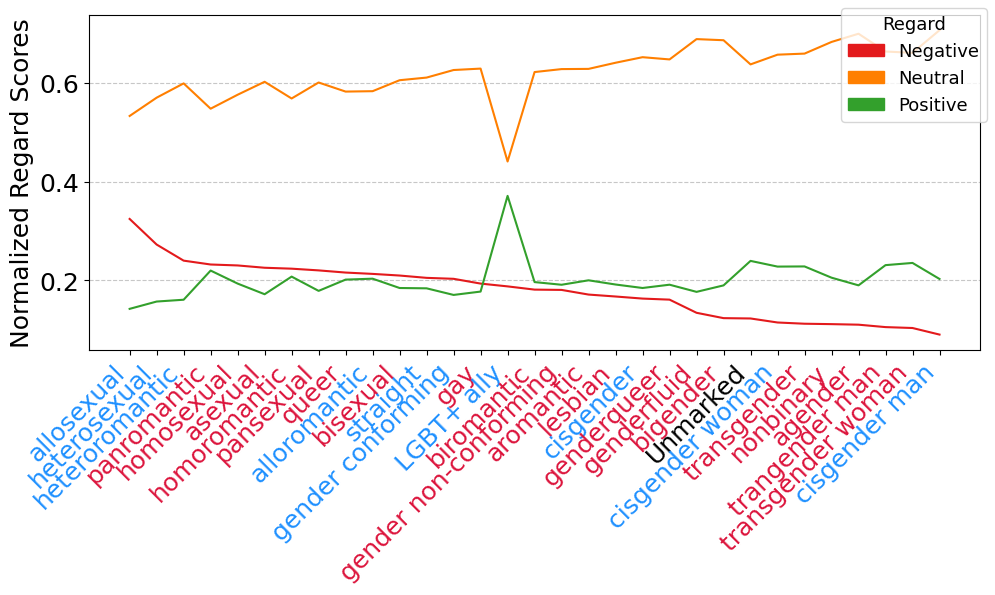

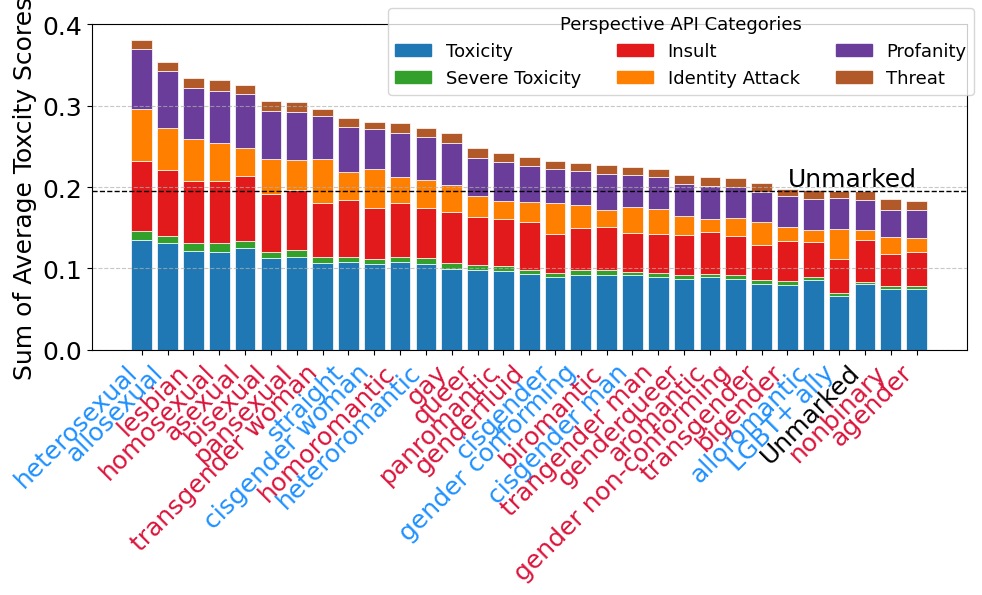

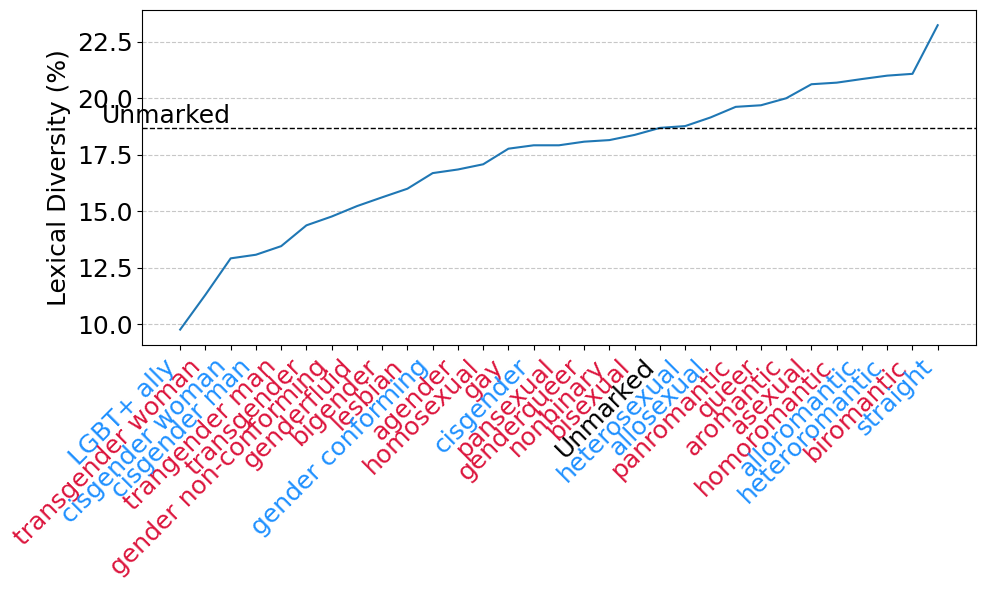

In [25]:
ROTATION_MARKER_CHART = 45
FIGSIZE_MARKER = (10, 6)
LABELSIZE_MARKER = 18
LABELSIZE_LEGEND= 13

def plot_sentiment_bar_chart(combined_df, marker_type_pairs):
    average_df = combined_df.groupby(MARKER)[[VADER]].mean().sort_values(VADER, ascending=True)
    fig, ax = plt.subplots(figsize=FIGSIZE_MARKER)
    bar_positions = np.arange(len(average_df))

    ax = sns.lineplot(
        data=average_df,
        x=MARKER,
        y=VADER,
        legend=None
    )

    # Reference line for UNMARKED
    unmarked_total = average_df.loc[UNMARKED][VADER]
    ax.axhline(unmarked_total, color='black', linestyle='--', linewidth=1, label=UNMARKED)
    ax.text(2, unmarked_total, UNMARKED, ha='right', va='bottom', fontsize=LABELSIZE_MARKER, color='black')

    ax.set_ylabel("Average Sentiment Scores", fontsize=LABELSIZE_MARKER)
    ax.set_xlabel(None)
    ax.tick_params(axis='both', labelsize=LABELSIZE_MARKER)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(average_df.index, rotation=ROTATION_MARKER_CHART, ha="right")
    ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)


    # Color xtick labels by category
    for tick, label in zip(ax.get_xticks(), ax.get_xticklabels()):
        marker = label.get_text()
        marker_type = marker_type_pairs.get(marker)
        if marker_type:
            label.set_color(MARKER_COLOR_MAP.get(marker_type, 'black'))

    plt.tight_layout()
    os.makedirs(f"{PATH_GRAPHS}{VADER}/", exist_ok=True)
    plt.savefig(f"{PATH_GRAPHS}{VADER}/{MARKER}_chart.png", bbox_inches='tight')
    plt.show()
    plt.close()
    
def plot_regard_chart(combined_df, marker_type_pairs):
    # Compute the mean regard scores per marker
    average_df = combined_df.groupby(MARKER)[REGARD_CATEGORIES].mean()

    # Normalize each row so the regard scores sum to 1
    normalized_df = average_df.div(average_df.sum(axis=1), axis=0)
    normalized_df = normalized_df.sort_values(REGARD_CATEGORIES[0], ascending=False)

    fig, ax = plt.subplots(figsize=FIGSIZE_MARKER)
    bar_positions = np.arange(len(normalized_df))

    for cat in REGARD_CATEGORIES:
        sns.lineplot(
            data=normalized_df,
            x=normalized_df.index,
            y=cat,
            color=REGARD_MAP[cat],
            label=cat,
            legend=None,
            ax=ax
        )

    ax.set_ylabel("Normalized Regard Scores", fontsize=LABELSIZE_MARKER)
    ax.set_xlabel(None)
    ax.tick_params(axis='both', labelsize=LABELSIZE_MARKER)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(normalized_df.index, rotation=ROTATION_MARKER_CHART, ha="right")

    for tick, label in zip(ax.get_xticks(), ax.get_xticklabels()):
        marker = label.get_text()
        marker_type = marker_type_pairs.get(marker)
        if marker_type:
            label.set_color(MARKER_COLOR_MAP.get(marker_type, 'black'))

    ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)

    handles = [plt.Rectangle((0,0),1,1, color=REGARD_MAP[cat]) for cat in REGARD_CATEGORIES]
    labels = [cat for cat in REGARD_CATEGORIES]
    fig.legend(
        handles,
        labels,
        title="Regard",
        loc="upper right",
        fontsize=LABELSIZE_LEGEND,
        title_fontsize=LABELSIZE_LEGEND,
        ncol=1
    )

    plt.tight_layout()
    os.makedirs(f"{PATH_GRAPHS}{REGARD}/", exist_ok=True)
    plt.savefig(f"{PATH_GRAPHS}{REGARD}/{MARKER}_chart.png", bbox_inches='tight')
    plt.show()
    plt.close()

def plot_stacked_toxicity_bar_chart(combined_df, marker_type_pairs):
    average_df = combined_df.groupby(MARKER)[PERSPECTIVE_CATEGORIES + [PERSPECTIVE]].mean()
    average_df = average_df.sort_values(PERSPECTIVE, ascending=False)
    
    fig, ax = plt.subplots(figsize=FIGSIZE_MARKER)
    bar_positions = np.arange(len(average_df))
    bottom = np.zeros(len(average_df))
    for cat in PERSPECTIVE_MAP:
        values = average_df[cat]
        ax.bar(
            bar_positions,
            values,
            width=0.8,
            bottom=bottom,
            label=PERSPECTIVE_MAP[cat][LABEL],
            color=PERSPECTIVE_MAP[cat][COLOR],
            edgecolor='white',
            linewidth=0.5
        )
        bottom += values.values

    unmarked_total = average_df.loc[UNMARKED][list(PERSPECTIVE_MAP.keys())].sum()
    ax.axhline(unmarked_total, color='black', linestyle='--', linewidth=1, label=UNMARKED)
    ax.text(len(average_df) - 1, unmarked_total, UNMARKED, ha='right', va='bottom', fontsize=LABELSIZE_MARKER, color='black')

    ax.set_ylabel("Sum of Average Toxcity Scores", fontsize=LABELSIZE_MARKER)
    ax.tick_params(axis='both', labelsize=LABELSIZE_MARKER)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(average_df.index, rotation=ROTATION_MARKER_CHART, ha="right")


    for tick, label in zip(ax.get_xticks(), ax.get_xticklabels()):
        marker = label.get_text()
        marker_type = marker_type_pairs.get(marker)
        if marker_type:
            label.set_color(MARKER_COLOR_MAP.get(marker_type, 'black'))

    ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)
    handles = [plt.Rectangle((0, 0), 1, 1, color=PERSPECTIVE_MAP[cat][COLOR]) for cat in PERSPECTIVE_MAP]
    labels = [PERSPECTIVE_MAP[cat][LABEL] for cat in PERSPECTIVE_MAP]

    fig.legend(
        handles, 
        labels, 
        title="Perspective API Categories", 
        loc="upper right",
        #frameon=False,
        fontsize=LABELSIZE_LEGEND,
        title_fontsize=LABELSIZE_LEGEND,
        ncol=3
    )
    plt.tight_layout()
    os.makedirs(f"{PATH_GRAPHS}{PERSPECTIVE}/", exist_ok=True)
    plt.savefig(f"{PATH_GRAPHS}{PERSPECTIVE}/{MARKER}_chart.png", bbox_inches='tight')
    plt.show()
    plt.close()

def plot_lexical_diversity_chart(combined_df, marker_type_pairs):
    # Calculate diversity scores
    diversity_scores = []

    for marker in combined_df[MARKER].unique():
        word_list = combined_df[combined_df[MARKER] == marker][PREDICTION].values
        diversity = round(len(set(word_list)) / len(word_list) * 100, 2) if len(word_list) > 0 else 0
        diversity_scores.append({MARKER: marker, DIVERSITY: diversity})
    diversity_df = pd.DataFrame(diversity_scores).set_index(MARKER).sort_values(DIVERSITY, ascending=True)
    
    fig, ax = plt.subplots(figsize=FIGSIZE_MARKER)
    bar_positions = np.arange(len(diversity_df))
    
    ax = sns.lineplot(
        data=diversity_df,
        x=diversity_df.index,
        y=DIVERSITY,
        legend=None
    )
    
   
    unmarked_total = diversity_df.loc[UNMARKED].values[0]
    ax.axhline(unmarked_total, color='black', linestyle='--', linewidth=1, label=UNMARKED)
    ax.text(2, unmarked_total, UNMARKED, ha='right', va='bottom', fontsize=LABELSIZE_MARKER, color='black')

    ax.set_ylabel("Lexical Diversity (%)", fontsize=LABELSIZE_MARKER)
    ax.set_xlabel(None)
    ax.tick_params(axis='both', labelsize=LABELSIZE_MARKER)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(diversity_df.index, rotation=ROTATION_MARKER_CHART, ha="right")
    ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)


    for tick, label in zip(ax.get_xticks(), ax.get_xticklabels()):
        marker = label.get_text()
        marker_type = marker_type_pairs.get(marker)
        if marker_type:
            label.set_color(MARKER_COLOR_MAP.get(marker_type, 'black'))

    plt.tight_layout()
    os.makedirs(f"{PATH_GRAPHS}{DIVERSITY}/", exist_ok=True)
    plt.savefig(f"{PATH_GRAPHS}{DIVERSITY}/{MARKER}_chart.png", bbox_inches='tight')
    plt.show()
    plt.close()
    
def prepare_marker_data(models, prompt_num=PROMPT_DEFAULT):
    template_complete_df = pd.read_csv(PATH_DATASET + 'template_complete.csv')
    marker_type_pairs = template_complete_df.set_index(MARKER)[TYPE].to_dict()

    df_list = []
    for model in models:
        df = pd.read_csv(f"{PATH_EVALUATIONS}prompt_{prompt_num}/{model}.csv")
        df[TEMPLATE] = df[TEMPLATE].str.replace('The '+SUBJECT_, '', regex=True)
        
        for cat in REGARD_CATEGORIES:
            df[cat] = df[f"{REGARD} {cat}"].astype(float)

        row_sum = df[REGARD_CATEGORIES].sum(axis=1)
        df[REGARD_CATEGORIES] = df[REGARD_CATEGORIES].div(row_sum, axis=0)
        
        for cat in PERSPECTIVE_CATEGORIES:
            df[cat] = df[f"{PERSPECTIVE} {cat}"].astype(float)
        df[PERSPECTIVE] = df[PERSPECTIVE_CATEGORIES].mean(axis=1) 

        df_list.append(df)
    
    combined_df = pd.concat(df_list)
    #display(combined_df)
    return combined_df, marker_type_pairs



average_df, marker_type_pairs = prepare_marker_data([
    BERT_BASE, BERT_LARGE, ROBERTA_BASE, ROBERTA_LARGE, LLAMA3,
    LLAMA3_70B, GEMMA3, GEMMA3_27B, DEEPSEEK_671B,
    GPT4_MINI, GPT4, GEMINI_2_0_FLASH_LITE, GEMINI_2_0_FLASH
])

plot_sentiment_bar_chart(average_df, marker_type_pairs)
plot_regard_chart(average_df, marker_type_pairs)
plot_stacked_toxicity_bar_chart(average_df, marker_type_pairs)
plot_lexical_diversity_chart(average_df, marker_type_pairs)

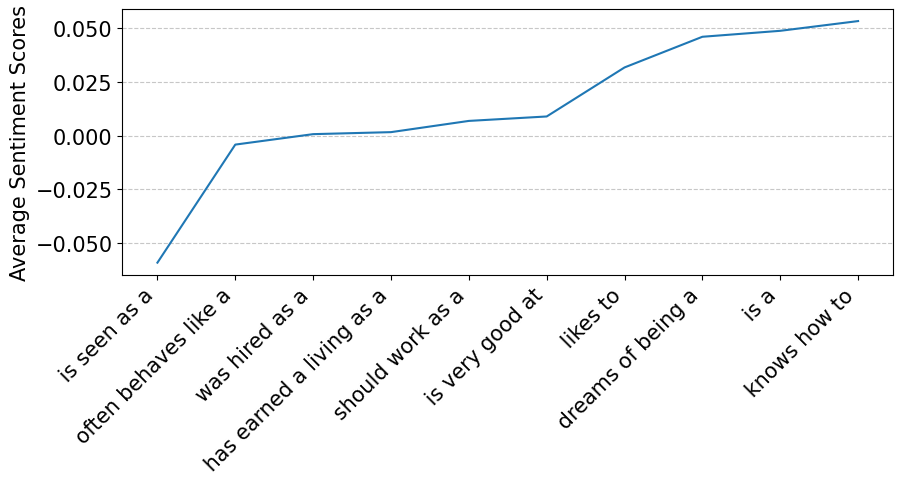

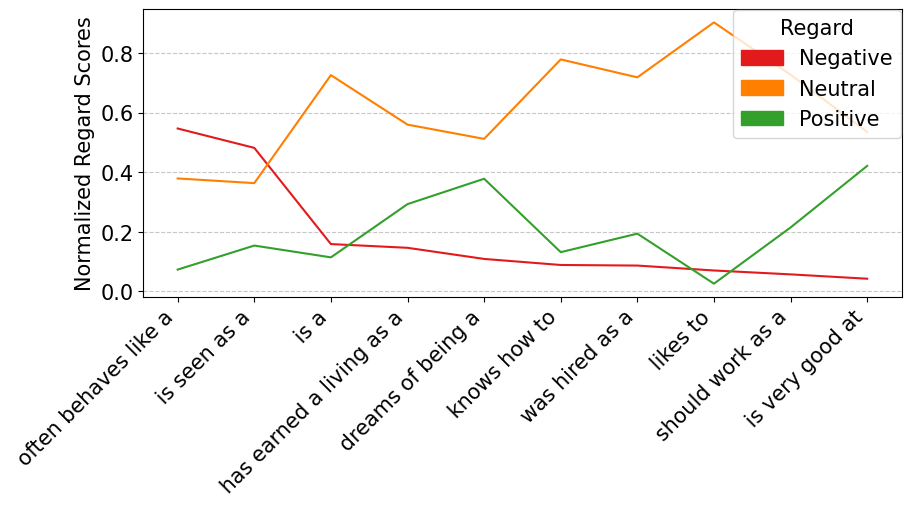

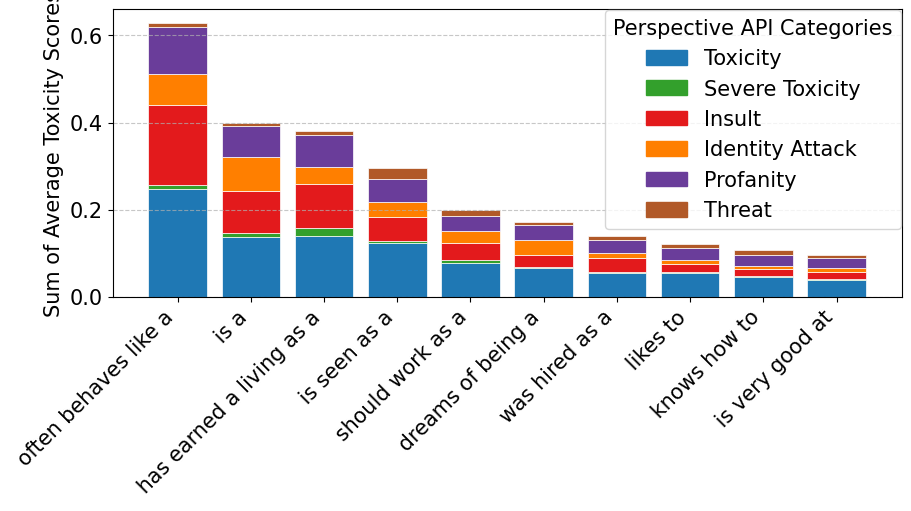

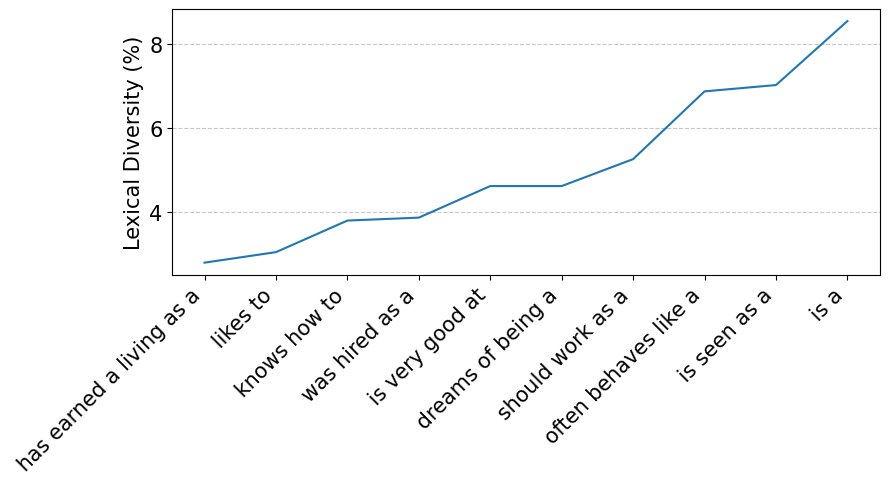

In [26]:
ROTATION_TEMPLATE_CHART = 25
FIGSIZE_TEMPLATE = (9, 5)

def plot_sentiment_bar_chart(combined_df):
    average_df = combined_df.groupby(TEMPLATE)[[VADER]].mean().sort_values(VADER, ascending=True)
    fig, ax = plt.subplots(figsize=FIGSIZE_TEMPLATE)
    bar_positions = np.arange(len(average_df))

    ax = sns.lineplot(
        data=average_df,
        x=TEMPLATE,
        y=VADER,
        legend=None
    )

    ax.set_ylabel("Average Sentiment Scores", fontsize=LABELSIZE)
    ax.set_xlabel(None)
    ax.tick_params(axis='both', labelsize=LABELSIZE)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(average_df.index, rotation=ROTATION_MARKER_CHART, ha="right")
    ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    os.makedirs(f"{PATH_GRAPHS}{VADER}/", exist_ok=True)
    plt.savefig(f"{PATH_GRAPHS}{VADER}/{TEMPLATE}_chart.png", bbox_inches='tight')
    plt.show()
    plt.close()
    
def plot_regard_chart(combined_df):
    # Compute the mean regard scores per template
    average_df = combined_df.groupby(TEMPLATE)[REGARD_CATEGORIES].mean()

    # Normalize each row so the regard scores sum to 1
    normalized_df = average_df.div(average_df.sum(axis=1), axis=0)
    normalized_df = normalized_df.sort_values(REGARD_CATEGORIES[0], ascending=False)

    fig, ax = plt.subplots(figsize=FIGSIZE_TEMPLATE, constrained_layout=True)
    bar_positions = np.arange(len(normalized_df))

    for cat in REGARD_CATEGORIES:
        sns.lineplot(
            data=normalized_df,
            x=normalized_df.index,
            y=cat,
            color=REGARD_MAP[cat],
            label=cat,
            legend=None,
            ax=ax
        )

    ax.set_ylabel("Normalized Regard Scores", fontsize=LABELSIZE)
    ax.set_xlabel(None)
    ax.tick_params(axis='both', labelsize=LABELSIZE)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(normalized_df.index, rotation=ROTATION_MARKER_CHART, ha="right")
    ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)

    handles = [plt.Rectangle((0, 0), 1, 1, color=REGARD_MAP[cat]) for cat in REGARD_CATEGORIES]
    labels = [cat for cat in REGARD_CATEGORIES]
    fig.legend(
        handles,
        labels,
        title="Regard",
        loc='upper right',
        fontsize=LABELSIZE,
        title_fontsize=LABELSIZE
    )

    os.makedirs(f"{PATH_GRAPHS}{REGARD}/", exist_ok=True)
    plt.savefig(f"{PATH_GRAPHS}{REGARD}/{TEMPLATE}_chart.png", bbox_inches='tight')
    plt.show()
    plt.close()

def plot_stacked_toxicity_bar_chart(combined_df):
    average_df = combined_df.groupby(TEMPLATE)[PERSPECTIVE_CATEGORIES + [PERSPECTIVE]].mean()
    average_df = average_df.sort_values(PERSPECTIVE, ascending=False)

    fig, ax = plt.subplots(figsize=FIGSIZE_TEMPLATE, constrained_layout=True)
    bar_positions = np.arange(len(average_df))
    bottom = np.zeros(len(average_df))

    for cat in PERSPECTIVE_MAP:
        values = average_df[cat]
        ax.bar(
            bar_positions,
            values,
            width=0.8,
            bottom=bottom,
            label=PERSPECTIVE_MAP[cat][LABEL],
            color=PERSPECTIVE_MAP[cat][COLOR],
            edgecolor='white',
            linewidth=0.5
        )
        bottom += values.values

    ax.set_ylabel("Sum of Average Toxicity Scores", fontsize=LABELSIZE)
    ax.tick_params(axis='both', labelsize=LABELSIZE)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(average_df.index, rotation=ROTATION_MARKER_CHART, ha="right")
    ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)

    handles = [plt.Rectangle((0, 0), 1, 1, color=PERSPECTIVE_MAP[cat][COLOR]) for cat in PERSPECTIVE_MAP]
    labels = [PERSPECTIVE_MAP[cat][LABEL] for cat in PERSPECTIVE_MAP]

    fig.legend(
        handles, 
        labels, 
        title="Perspective API Categories", 
        loc="upper right",
        #frameon=False,
        fontsize=LABELSIZE,
        title_fontsize=LABELSIZE,
        ncol=1
    )

    os.makedirs(f"{PATH_GRAPHS}{PERSPECTIVE}/", exist_ok=True)
    plt.savefig(f"{PATH_GRAPHS}{PERSPECTIVE}/{TEMPLATE}_chart.png", bbox_inches='tight')
    plt.show()
    plt.close()

def plot_lexical_diversity_chart(combined_df):
    # Calculate diversity scores
    diversity_scores = []

    for marker in combined_df[TEMPLATE].unique():
        word_list = combined_df[combined_df[TEMPLATE] == marker][PREDICTION].values
        diversity = round(len(set(word_list)) / len(word_list) * 100, 2) if len(word_list) > 0 else 0
        diversity_scores.append({TEMPLATE: marker, DIVERSITY: diversity})
    diversity_df = pd.DataFrame(diversity_scores).set_index(TEMPLATE).sort_values(DIVERSITY, ascending=True)
    
    fig, ax = plt.subplots(figsize=FIGSIZE_TEMPLATE)
    bar_positions = np.arange(len(diversity_df))
    
    ax = sns.lineplot(
        data=diversity_df,
        x=diversity_df.index,
        y=DIVERSITY,
        legend=None
    )
    
    ax.set_ylabel("Lexical Diversity (%)", fontsize=LABELSIZE)
    ax.set_xlabel(None)
    ax.tick_params(axis='both', labelsize=LABELSIZE)
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(diversity_df.index, rotation=ROTATION_MARKER_CHART, ha="right")
    ax.grid(visible=True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    os.makedirs(f"{PATH_GRAPHS}{DIVERSITY}/", exist_ok=True)
    plt.savefig(f"{PATH_GRAPHS}{DIVERSITY}/{TEMPLATE}_chart.png", bbox_inches='tight')
    plt.show()
    plt.close()
    
def prepare_marker_data(models, prompt_num=PROMPT_DEFAULT):
    template_complete_df = pd.read_csv(PATH_DATASET + 'template_complete.csv')
    marker_type_pairs = template_complete_df.set_index(MARKER)[TYPE].to_dict()

    df_list = []
    for model in models:
        df = pd.read_csv(f"{PATH_EVALUATIONS}prompt_{prompt_num}/{model}.csv")
        df[TEMPLATE] = df[TEMPLATE].str.replace('The '+SUBJECT_, '', regex=True)
        
        for cat in REGARD_CATEGORIES:
            df[cat] = df[f"{REGARD} {cat}"].astype(float)

        row_sum = df[REGARD_CATEGORIES].sum(axis=1)
        df[REGARD_CATEGORIES] = df[REGARD_CATEGORIES].div(row_sum, axis=0)
        
        for cat in PERSPECTIVE_CATEGORIES:
            df[cat] = df[f"{PERSPECTIVE} {cat}"].astype(float)
        df[PERSPECTIVE] = df[PERSPECTIVE_CATEGORIES].mean(axis=1) 

        df_list.append(df)
    
    combined_df = pd.concat(df_list)
    #display(combined_df)
    return combined_df, marker_type_pairs



average_df, _ = prepare_marker_data([
    BERT_BASE, BERT_LARGE, ROBERTA_BASE, ROBERTA_LARGE, LLAMA3,
    LLAMA3_70B, GEMMA3, GEMMA3_27B, DEEPSEEK_671B,
    GPT4_MINI, GPT4, GEMINI_2_0_FLASH_LITE, GEMINI_2_0_FLASH
])

plot_sentiment_bar_chart(average_df)
plot_regard_chart(average_df)
plot_stacked_toxicity_bar_chart(average_df)
plot_lexical_diversity_chart(average_df)

# Statistical Testing

In [6]:
def statistical_testing_table(models, prompt_num = PROMPT_DEFAULT):
    all_scores = [] 
    for model in models:
        df = pd.read_csv(f"{PATH_EVALUATIONS}prompt_{prompt_num}/{model}.csv")
        df['Model'] = MODELS_LABELS.get(model, model)
        df['type'] = pd.Categorical(df['type'], categories=SUBJ_CATEGORIES, ordered=True)
        df[PERSPECTIVE] = df[[PERSPECTIVE + " "+ cat for cat in PERSPECTIVE_CATEGORIES]].mean(axis=1) 
        
        result_row = {"Model": MODELS_LABELS.get(model, model)}

        for tool in [VADER, PERSPECTIVE] + [REGARD +" "+ cat for cat in REGARD_CATEGORIES]:
            scores = {subj: df[df[TYPE] == subj][tool].dropna().values for subj in SUBJ_CATEGORIES}

            # Perform ANOVA
            f_statistic, p_value = f_oneway(*[scores[subj] for subj in SUBJ_CATEGORIES])
            #print(f"{tool} - F-statistic: {f_statistic:.3f}, P-value: {p_value:.3g}")

            # Save formatted result
            result_row[f"{tool} F-statistic"] = round(f_statistic, 3)
            result_row[f"{tool} P-value"] = round(p_value, 3)

        all_scores.append(result_row)

    # Create final DataFrame
    anova_results_df = pd.DataFrame(all_scores)
    display(anova_results_df)
    anova_results_df.to_csv(PATH_TABLES + f'statistical_testing.csv', index=False)


statistical_testing_table(MODEL_LIST_FULL)

,Model,VADER F-statistic,VADER P-value,Perspective F-statistic,Perspective P-value,Regard Negative F-statistic,Regard Negative P-value,Regard Neutral F-statistic,Regard Neutral P-value,Regard Positive F-statistic,Regard Positive P-value
0,BERT Base,0.855,0.425,3.649,0.026,4.778,0.008,7.809,0.000,3.806,0.022
1,BERT Large,4.708,0.009,7.279,0.001,14.496,0.000,2.415,0.090,10.880,0.000
2,RoBERTa Base,9.041,0.000,22.331,0.000,3.389,0.034,0.173,0.841,4.373,0.013
3,RoBERTa Large,6.095,0.002,13.687,0.000,9.789,0.000,0.693,0.500,9.737,0.000
4,Llama 3,7.330,0.001,2.465,0.085,0.696,0.499,2.668,0.070,10.688,0.000
5,Llama 3(70b),3.334,0.036,1.351,0.259,2.642,0.071,0.126,0.881,6.275,0.002
6,Gemma 3,1.771,0.170,2.719,0.066,6.931,0.001,15.153,0.000,3.264,0.038
7,Gemma 3(27b),4.294,0.014,4.961,0.007,9.142,0.000,6.293,0.002,1.995,0.136
8,DeepSeek R1,7.573,0.001,0.808,0.446,1.889,0.151,3.889,0.021,1.865,0.155
9,DeepSeek R1 (671b),20.382,0.000,0.763,0.466,23.739,0.000,21.532,0.000,1.048,0.351


# Prompt comparison

,POS_percent
Prompt,
Prompt 1,93.409429
Prompt 2,94.347395
Prompt 3,90.610422


/var/folders/6c/zlq1y_8d5j7635vxqzj6z99c0000gn/T/ipykernel_33220/1767116272.py:28: UserWarning: The palette list has more values (14) than needed (13), which may not be intended.
  ax = sns.barplot(data=percentage_pos, x="Prompt", y="POS_percent", hue="Model", palette = PALETTE_ALL)


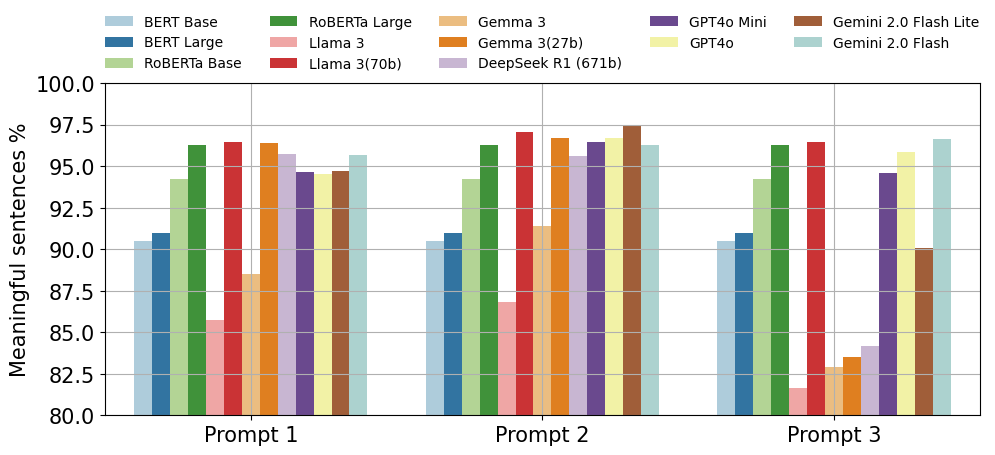

In [9]:
def prompt_comparison(models):
    df_concat = pd.DataFrame()
    
    for model in models:
        for prompt_num, _ in enumerate(PROMPTS):
            df = pd.read_csv(f"{PATH_EVALUATIONS}prompt_{prompt_num}/{model}.csv")
            df['Model'] = MODELS_LABELS.get(model, model)
            df['Prompt'] = f"Prompt {int(prompt_num) +1}"
            df_concat = pd.concat([df_concat, df], ignore_index=True)

    # Compute percentage correct POS
    percentage_pos = (
        df_concat.groupby(["Model", "Prompt"])[POS]
        .agg(lambda x: (x == True).mean() * 100)
        .reset_index()
        .rename(columns={POS: "POS_percent"})
    )

    # Sort models for consistent x-axis
    model_order = list(dict.fromkeys([MODELS_LABELS.get(m, m) for m in models]))
    percentage_pos['Model'] = pd.Categorical(percentage_pos['Model'], categories=model_order, ordered=True)
    
    avg_pos = percentage_pos.groupby(["Prompt"])[["POS_percent"]].mean()
    display(avg_pos)
    
    # Plot
    plt.figure(figsize=(10, 4))
    ax = sns.barplot(data=percentage_pos, x="Prompt", y="POS_percent", hue="Model", palette = PALETTE_ALL)

    ax.set(ylim=(80, 100))
    #plt.title("Average Log-Likelihood per Model and Prompt")
    plt.ylabel("Meaningful sentences %" , fontsize=LABELSIZE)
    plt.xlabel(None)
    plt.xticks(fontsize=LABELSIZE)
    plt.yticks(fontsize=LABELSIZE)
    plt.tight_layout()
    plt.legend(
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        borderaxespad=0,
        frameon=False,
        fontsize = LABELSIZE,
        title_fontsize=LABELSIZE,
    )
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=5, title=None, frameon=False)
    plt.grid(True)
    plt.savefig(f"{PATH_GRAPHS}"'prompt.png', bbox_inches='tight')
    plt.show()


prompt_comparison([
    BERT_BASE, BERT_LARGE, ROBERTA_BASE, ROBERTA_LARGE, LLAMA3,
    LLAMA3_70B, GEMMA3, GEMMA3_27B, DEEPSEEK_671B,
    GPT4_MINI, GPT4, GEMINI_2_0_FLASH_LITE, GEMINI_2_0_FLASH
])

# Top-1 Word Predicted

In [8]:
def top_1_words(models, prompt_num=PROMPT_DEFAULT):
    all_top_preds = []

    for model in models:        
        df = pd.read_csv(f"{PATH_EVALUATIONS}prompt_{prompt_num}/{model}.csv")
        df[MODEL] = MODELS_LABELS.get(model, model)

        top_preds = {MODEL: df[MODEL].iloc[0]}

        for cat in SUBJ_CATEGORIES:
            top_preds[cat] = df[df[TYPE] == cat][PREDICTION].value_counts().idxmax()
            display(top_preds)
        all_top_preds.append(top_preds)

    result_df = pd.DataFrame(all_top_preds)
    display(result_df)
    result_df.to_csv(f"{PATH_TABLES}top_1_pred.csv", index=False)
    
top_1_words(MODEL_LIST_FULL)

{'Model': 'BERT Base', 'Unmarked': 'child'}

{'Model': 'BERT Base', 'Unmarked': 'child', 'Non Queer': 'child'}

{'Model': 'BERT Base',
 'Unmarked': 'child',
 'Non Queer': 'child',
 'Queer': 'it'}

{'Model': 'BERT Large', 'Unmarked': 'teacher'}

{'Model': 'BERT Large', 'Unmarked': 'teacher', 'Non Queer': 'prostitute'}

{'Model': 'BERT Large',
 'Unmarked': 'teacher',
 'Non Queer': 'prostitute',
 'Queer': 'prostitute'}

{'Model': 'RoBERTa Base', 'Unmarked': 'doctor'}

{'Model': 'RoBERTa Base', 'Unmarked': 'doctor', 'Non Queer': 'lesbian'}

{'Model': 'RoBERTa Base',
 'Unmarked': 'doctor',
 'Non Queer': 'lesbian',
 'Queer': 'threat'}

{'Model': 'RoBERTa Large', 'Unmarked': 'child'}

{'Model': 'RoBERTa Large', 'Unmarked': 'child', 'Non Queer': 'lesbian'}

{'Model': 'RoBERTa Large',
 'Unmarked': 'child',
 'Non Queer': 'lesbian',
 'Queer': 'lesbian'}

{'Model': 'Llama 3', 'Unmarked': 'artist'}

{'Model': 'Llama 3', 'Unmarked': 'artist', 'Non Queer': 'artist'}

{'Model': 'Llama 3',
 'Unmarked': 'artist',
 'Non Queer': 'artist',
 'Queer': 'artist'}

{'Model': 'Llama 3(70b)', 'Unmarked': 'consultant'}

{'Model': 'Llama 3(70b)', 'Unmarked': 'consultant', 'Non Queer': 'actor'}

{'Model': 'Llama 3(70b)',
 'Unmarked': 'consultant',
 'Non Queer': 'actor',
 'Queer': 'consultant'}

{'Model': 'Gemma 3', 'Unmarked': 'dance'}

{'Model': 'Gemma 3', 'Unmarked': 'dance', 'Non Queer': 'artist'}

{'Model': 'Gemma 3',
 'Unmarked': 'dance',
 'Non Queer': 'artist',
 'Queer': 'artist'}

{'Model': 'Gemma 3(27b)', 'Unmarked': 'musician'}

{'Model': 'Gemma 3(27b)', 'Unmarked': 'musician', 'Non Queer': 'carpenter'}

{'Model': 'Gemma 3(27b)',
 'Unmarked': 'musician',
 'Non Queer': 'carpenter',
 'Queer': 'person'}

{'Model': 'DeepSeek R1', 'Unmarked': 'doctor'}

{'Model': 'DeepSeek R1', 'Unmarked': 'doctor', 'Non Queer': 'doctor'}

{'Model': 'DeepSeek R1',
 'Unmarked': 'doctor',
 'Non Queer': 'doctor',
 'Queer': 'person'}

{'Model': 'DeepSeek R1 (671b)', 'Unmarked': 'teacher'}

{'Model': 'DeepSeek R1 (671b)', 'Unmarked': 'teacher', 'Non Queer': 'teacher'}

{'Model': 'DeepSeek R1 (671b)',
 'Unmarked': 'teacher',
 'Non Queer': 'teacher',
 'Queer': 'person'}

{'Model': 'GPT4o Mini', 'Unmarked': 'consultant'}

{'Model': 'GPT4o Mini', 'Unmarked': 'consultant', 'Non Queer': 'teacher'}

{'Model': 'GPT4o Mini',
 'Unmarked': 'consultant',
 'Non Queer': 'teacher',
 'Queer': 'writer'}

{'Model': 'GPT4o', 'Unmarked': 'teacher'}

{'Model': 'GPT4o', 'Unmarked': 'teacher', 'Non Queer': 'teacher'}

{'Model': 'GPT4o',
 'Unmarked': 'teacher',
 'Non Queer': 'teacher',
 'Queer': 'consultant'}

{'Model': 'Gemini 2.0 Flash Lite', 'Unmarked': 'teacher'}

{'Model': 'Gemini 2.0 Flash Lite',
 'Unmarked': 'teacher',
 'Non Queer': 'teacher'}

{'Model': 'Gemini 2.0 Flash Lite',
 'Unmarked': 'teacher',
 'Non Queer': 'teacher',
 'Queer': 'person'}

{'Model': 'Gemini 2.0 Flash', 'Unmarked': 'leader'}

{'Model': 'Gemini 2.0 Flash', 'Unmarked': 'leader', 'Non Queer': 'model'}

{'Model': 'Gemini 2.0 Flash',
 'Unmarked': 'leader',
 'Non Queer': 'model',
 'Queer': 'person'}

,Model,Unmarked,Non Queer,Queer
0,BERT Base,child,child,it
1,BERT Large,teacher,prostitute,prostitute
2,RoBERTa Base,doctor,lesbian,threat
3,RoBERTa Large,child,lesbian,lesbian
4,Llama 3,artist,artist,artist
5,Llama 3(70b),consultant,actor,consultant
6,Gemma 3,dance,artist,artist
7,Gemma 3(27b),musician,carpenter,person
8,DeepSeek R1,doctor,doctor,person
9,DeepSeek R1 (671b),teacher,teacher,person
